## Experiment with flight data APIs

Initial goal: compare deterministic optimal (cheapest) flight search to agent-driven one

In [1]:
from utils.utils import get_flights_to_destinations, plot_price_distribution

import nest_asyncio
nest_asyncio.apply()

import json
import pandas as pd
from datetime import datetime

from dotenv import load_dotenv
load_dotenv()
import os

from openai import AsyncOpenAI
client = AsyncOpenAI()
from agents import Agent, Runner, ModelSettings, WebSearchTool

from IPython.display import Markdown, display

import warnings
warnings.filterwarnings("ignore")

Test query with the function

In [2]:
flights_df = get_flights_to_destinations(
    date="2025-05-02",
    from_airport="EWR",
    to_airports=[
        "ORY",  # Orly
        "CDG",  # Charles de Gaulle
    ],
    max_stops=1,
    #trip="one-way",
    #passengers_adults=2,
)

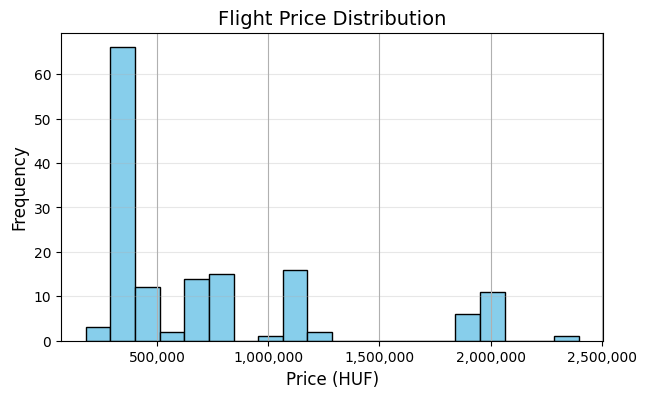

In [3]:
fig = plot_price_distribution(flights_df)

In [4]:
pd.DataFrame(flights_df['name'].value_counts())

,count
name,
Tap Air Portugal,32
Delta,19
"Delta, Air France",13
United,11
"United, Tap Air Portugal",8
British Airways,6
Air Canada,6
Lufthansa,5
Turkish Airlines,5


In [5]:
flights_df.head(3)

,price,departure_date,departure_time,arrival_date,arrival_time,duration_hours,name,stops,is_best,price_denomination
0,179194,2025-05-02,23:00,2025-05-03,12:15,7.250,French bee,0,True,HUF
1,403785,2025-05-02,20:25,2025-05-03,21:55,19.500,Self transferThis trip includes tickets from m...,1,True,HUF
2,601430,2025-05-02,20:20,2025-05-03,19:25,17.083,LOT,1,True,HUF


### General tool-calling agent

Showcasing tool calling capabilities by assigning the above function as a tool to an OpenAI model. Tool will return with the pandas under the hood, the AI will analyze the content and provide an answer

1. Set up custom tool

In [2]:
from utils.utils import get_flights_to_destinations_tool

2. Set up OpenAI responses API wrapper

In [29]:
system_message = "You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability."

user_message_template = """
<current_datetime>
The current date and time is {current_datetime}.
</current_datetime>

<instructions>
Your sole purpose is to answer user's questions. You aim to be informative and helpful, providing concise but complete answers. The user may ask you any questions. For general questions, use your own knowledge. For flight information, use the available tools.

When answering about flights, be thorough in your response. Include information about the price distribution, offer a few different options across various airlines and times, and highlight the best deal based on price and convenience. Mention both the cheapest options and any premium alternatives that might provide better value.
</instructions>

<user_question>
{question}
</user_question>
"""

async def ai(question: str, tools=[get_flights_to_destinations_tool], stream=False, model="gpt-4.1"):
    
    current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M')
    
    agent = Agent(
        name="Flight Assistant",
        instructions=system_message,
        model=model,
        tools=tools,
    )
    
    formatted_question = user_message_template.format(
        question=question,
        current_datetime=current_datetime
    )
    
    if stream:
        # TODO implement streaming
        result = await Runner.run(agent, formatted_question)
        return result
    else:
        result = await Runner.run(agent, formatted_question)
        return result

Simple test

In [17]:
q = 'what is the difference between declarative and imperative?'
a = await ai(q, stream=True)

In [18]:
display(Markdown(a.final_output))

The difference between declarative and imperative refers to two different styles of expressing instructions or logic, especially in programming, but also in other contexts like language and logic:

**Imperative:**
- Describes how to do something, step by step.
- Focuses on the process and control flow.
- Gives explicit commands for every action needed to reach the goal.
- Example (in programming):  
  ```
  let sum = 0;
  for (let i = 1; i <= 100; i++) {
      sum += i;
  }
  ```
  (You are telling the computer exactly how to sum numbers from 1 to 100.)

**Declarative:**
- Describes what you want to achieve, without necessarily detailing how to do it.
- Focuses on the outcome.
- Lets the underlying system figure out the steps to reach the desired result.
- Example (in programming):  
  ```
  sum = sum(1..100)
  ```
  (You declare that you want the sum of numbers from 1 to 100, but don’t specify how to iterate.)

**Summary:**  
Imperative tells "how" to do it (gives instructions step by step), while declarative tells "what" to do (states the desired result).

Test with flight related question

In [30]:
q = 'How much would it cost to fly from Budapest to London on 2025-04-25?'
a = await ai(q, stream=True)

In [31]:
display(Markdown(a.final_output))

Here are the flight options from Budapest (BUD) to London on 2025-04-25:

### Cheapest Options (All Prices in HUF)
- Ryanair: from 60,644 HUF
  - Departure: 05:45 | Arrival: 07:20 | Duration: 2h 35m
  - Other Ryanair options: 09:50 (arr. 11:25), 15:15 (arr. 16:50), 22:40 (arr. 00:15 next day)

- Wizz Air: from 75,960 HUF
  - Departure: 06:00 | Arrival: 07:45 | Duration: 2h 45m
  - Other Wizz Air options: 08:40, 13:15, 17:00, 16:45

- easyJet: 107,700 HUF
  - Departure: 21:05 | Arrival: 22:45 | Duration: 2h 40m

### Premium Options
- British Airways: from 251,200 HUF
  - Departure: 12:55 | Arrival: 14:40 | Duration: 2h 45m
  - Other BA options: 14:55, 17:45, 07:10

### Price Distribution
- Ultra low-cost (Ryanair, Wizz Air): 60,644–120,518 HUF
- Standard/Legacy (British Airways): 251,200–526,000 HUF

### Recommendations

- Best value (cheapest): Ryanair departing 05:45, 60,644 HUF—direct, early morning.
- Most convenient (premium): British Airways at midday (12:55), 251,200 HUF—direct, full-service airline.

If you want something in between (later time but still low cost), look at Wizz Air’s 17:00 flight for 76,580 HUF.

Let me know if you have a preferred time, airline, or want details on baggage, return flights, or airport options!

In [32]:
a.new_items

[ToolCallItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='gpt-4.1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description="Fetch flights to multiple destinations and return a combined DataFrame.\n\nNote: The fast_flights API doesn't support multiple destinations in a single call,\nso this function makes separate API calls for each destination and combines the results.", params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airpor

In [33]:
a.raw_responses

[ModelResponse(output=[ResponseFunctionToolCall(id='fc_6805845ab98881928f0064c17e3b93bf066620510e0f31e1', arguments='{"date":"2025-04-25","from_airport":"BUD","to_airports":["LHR","LGW","LTN","STN","LCY"],"max_stops":0}', call_id='call_bPRXHXpgFfTgU0CEqml0J5wH', name='get_flights_to_destinations_tool', type='function_call', status='completed')], usage=Usage(requests=1, input_tokens=390, output_tokens=58, total_tokens=448), referenceable_id='resp_68058459fd7c8192888b55b0c3216836066620510e0f31e1'),
 ModelResponse(output=[ResponseOutputMessage(id='msg_6805848233148192a3d7df290967a169066620510e0f31e1', content=[ResponseOutputText(annotations=[], text='Here are the flight options from Budapest (BUD) to London on 2025-04-25:\n\n### Cheapest Options (All Prices in HUF)\n- Ryanair: from 60,644 HUF\n  - Departure: 05:45 | Arrival: 07:20 | Duration: 2h 35m\n  - Other Ryanair options: 09:50 (arr. 11:25), 15:15 (arr. 16:50), 22:40 (arr. 00:15 next day)\n\n- Wizz Air: from 75,960 HUF\n  - Departure

Complex question

In [43]:
model_for_complex_question = 'o1'

q = 'I want to find the best deal for flying to Madeira from Budapest any time between 2025-07-01 and 2025-07-15. I will want to spend at least 5, at most 8 days there. I will be traveling with my girlfriend. Ideally I only want to have at most 1 stop. Find the optimal flight for me. I want to have the cheapest flight possible.'
a = await ai(q, model=model_for_complex_question)

In [46]:
display(Markdown(a.final_output))

Below is an option that, based on currently available data, yields the lowest total fare (departure on July 1, returning on July 8). This trip length is 6 nights on the ground in Madeira (arriving the morning of July 2 and leaving on July 8), which fits your “5 to 8 days” requirement.

1) Outbound (Budapest → Madeira):
   • Date/Time: Departs Tue, July 1 at 20:00, arrives Wed, July 2 at 09:35  
   • Airline(s): SWISS + Edelweiss Air (1 stop)  
   • Duration: ~14h 35m  
   • Price: 180,800 HUF

2) Return (Madeira → Budapest):
   • Date/Time: Departs Tue, July 8 at 09:50, arrives Wed, July 9 at 07:50  
   • “Self-transfer” itinerary with 1 stop (multiple carriers)  
   • Price: 82,651 HUF

Total Fare (per person): 180,800 + 82,651 = 263,451 HUF  
For two travelers, simply double that amount.

Why this is optimal for a budget:
• Among all combinations checked (departing July 1, returning on different dates between July 6 and July 9 to satisfy 5–8 days), this pairing yields the lowest combined cost.  
• If you prefer fewer stopovers or a shorter travel time, there are single-stop or direct flights with slightly higher fares (for example, returning on July 7 for around 110,000 HUF rather than ~83,000 HUF on July 8). However, they add to the overall ticket price.

If you have flexibility to change departure dates, it is worth checking July 2 or 3 departures as well—sometimes midweek can be cheaper. But with the data at hand, this July 1–8 plan is the least expensive option.

In [44]:
a.new_items

[ReasoningItem(agent=Agent(name='Flight Assistant', instructions="You are a helpful personal assistant. You are able to get real-time flight information for a given destination and date. You answer users' questions about flight prices and availability.", handoff_description=None, handoffs=[], model='o1', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=False, truncation=None, max_tokens=None), tools=[FunctionTool(name='get_flights_to_destinations_tool', description="Fetch flights to multiple destinations and return a combined DataFrame.\n\nNote: The fast_flights API doesn't support multiple destinations in a single call,\nso this function makes separate API calls for each destination and combines the results.", params_json_schema={'properties': {'date': {'description': 'Flight date in YYYY-MM-DD format', 'title': 'Date', 'type': 'string'}, 'from_airport': {'description': 'Departure airport co